In [25]:
import os, glob
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

all_files = glob.glob("*.csv")
df_list = []
for fp in all_files:
    tmp = pd.read_csv(fp)
    tmp["game_id"] = os.path.splitext(os.path.basename(fp))[0]
    df_list.append(tmp)
df = pd.concat(df_list, ignore_index=True)

CATEGORICAL_FEATURES = ["Balls", "Strikes", "Outs", "Inning", "PitcherId"]
TARGET = "AutoPitchType"



df = df.dropna(subset=[TARGET])


df["ball_strike_sum"] = df["Balls"] + df["Strikes"]

df["full_count"] = (df["ball_strike_sum"] == 3).astype(int)

df["two_outs"] = (df["Outs"] == 2).astype(int)

df["late_inning"] = (df["Inning"] >= 7).astype(int)

NUMERIC_FEATURES = ["ball_strike_sum", "full_count", "two_outs", "late_inning"]
summary_cols = [
    "Balls", "Strikes", "Outs", "Inning",
    "RelSpeed", "VertRelAngle", "HorzRelAngle",
    "ball_strike_sum", "full_count", "two_outs", "late_inning"
]

stats = df[summary_cols].agg(["min", "max", "mean", "std"]).T
stats.columns = ["Min", "Max", "Mean", "StdDev"]

print(stats)

X = df[CATEGORICAL_FEATURES + NUMERIC_FEATURES]
y = df[TARGET]
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

CARD_THRESHOLD = 10
low_card = [c for c in CATEGORICAL_FEATURES if X_train[c].nunique() <= CARD_THRESHOLD]
high_card = [c for c in CATEGORICAL_FEATURES if X_train[c].nunique() >  CARD_THRESHOLD]


cat_low_pipe = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("ohe", OneHotEncoder(handle_unknown="ignore", sparse_output=False)),
])
cat_high_pipe = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("ord", OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1)),
])


num_pipe = Pipeline([
    ("imputer", SimpleImputer(strategy="mean")),
    ("scaler", StandardScaler()),
])

preprocessor = ColumnTransformer([
    ("cat_low",  cat_low_pipe,  low_card),
    ("cat_high", cat_high_pipe, high_card),
    ("num",      num_pipe,      NUMERIC_FEATURES),
])


model = Pipeline([
    ("prep", preprocessor),
    ("rf", RandomForestClassifier(
        n_estimators=500,
        max_depth=7,
        random_state=42,
        n_jobs=-1
    )),
])

model.fit(X_train, y_train)

# --- 9) Evaluate ---
y_pred = model.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

                       Min         Max       Mean    StdDev
Balls             0.000000    3.000000   0.894415  0.972439
Strikes           0.000000    2.000000   0.832731  0.819606
Outs              0.000000    2.000000   0.942901  0.822561
Inning            1.000000   10.000000   4.852320  2.510172
RelSpeed         53.106740  100.229820  87.683353  5.313174
VertRelAngle     -5.134428    5.003017  -0.988408  1.311912
HorzRelAngle     -7.308295    8.238125  -1.314299  2.491468
ball_strike_sum   0.000000    5.000000   1.727146  1.471612
full_count        0.000000    1.000000   0.159072  0.365769
two_outs          0.000000    1.000000   0.311336  0.463072
late_inning       0.000000    1.000000   0.302723  0.459468
Accuracy: 0.3701388888888889
              precision    recall  f1-score   support

    Changeup       0.25      0.01      0.01       167
   Curveball       0.00      0.00      0.00       125
      Cutter       0.00      0.00      0.00        54
   Four-Seam       0.37      0.92 

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [26]:
for df_ in [X_train, X_test]:
    df_[CATEGORICAL_FEATURES] = (
        df_[CATEGORICAL_FEATURES]
        .fillna("MISSING")
        .astype(str)
    )

cat_features = list(range(len(CATEGORICAL_FEATURES)))

from catboost import CatBoostClassifier

cbc = CatBoostClassifier(
    iterations=500,
    learning_rate=0.1,
    depth=6,
    random_seed=42,
    verbose=100
)


cbc.fit(
    X_train, y_train,
    cat_features=cat_features,
    eval_set=(X_test, y_test)
)

from sklearn.metrics import accuracy_score, classification_report
y_pred_cb = cbc.predict(X_test)
print("CatBoost Accuracy:", accuracy_score(y_test, y_pred_cb))
print(classification_report(y_test, y_pred_cb))

0:	learn: 1.8909036	test: 1.8909187	best: 1.8909187 (0)	total: 18.3ms	remaining: 9.11s
100:	learn: 1.3047743	test: 1.4196731	best: 1.4192540 (99)	total: 11s	remaining: 43.5s
200:	learn: 1.1746855	test: 1.4097795	best: 1.4092435 (194)	total: 23.4s	remaining: 34.7s
300:	learn: 1.0683440	test: 1.4121957	best: 1.4086189 (210)	total: 35.4s	remaining: 23.4s
400:	learn: 0.9799895	test: 1.4151457	best: 1.4086189 (210)	total: 47.5s	remaining: 11.7s
499:	learn: 0.8974572	test: 1.4220999	best: 1.4086189 (210)	total: 59.6s	remaining: 0us

bestTest = 1.408618935
bestIteration = 210

Shrink model to first 211 iterations.
CatBoost Accuracy: 0.44166666666666665
              precision    recall  f1-score   support

    Changeup       0.49      0.18      0.26       167
   Curveball       0.33      0.09      0.14       125
      Cutter       0.36      0.09      0.15        54
   Four-Seam       0.47      0.74      0.57       500
      Sinker       0.45      0.43      0.44       256
      Slider       0.

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


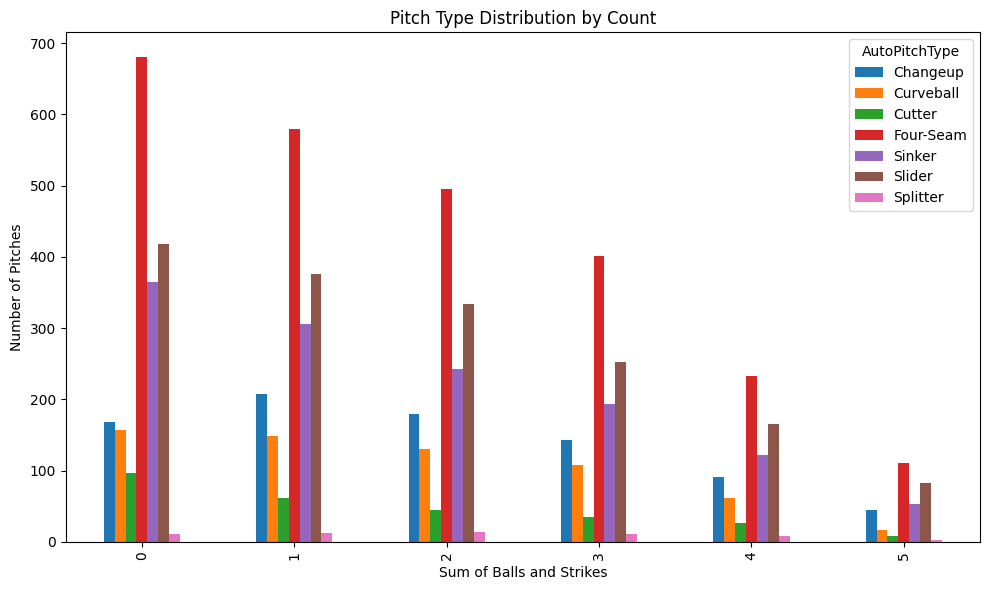

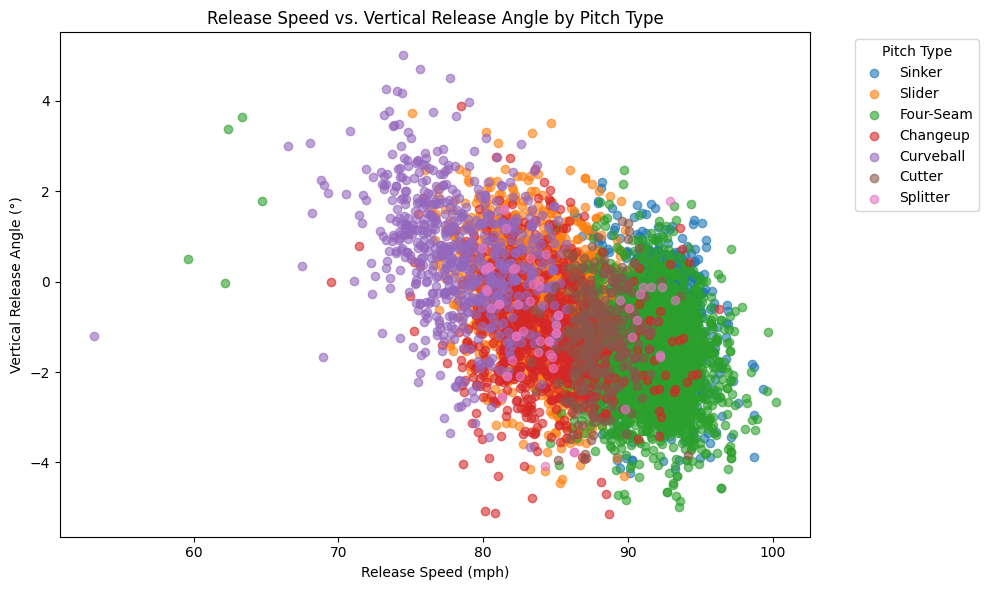

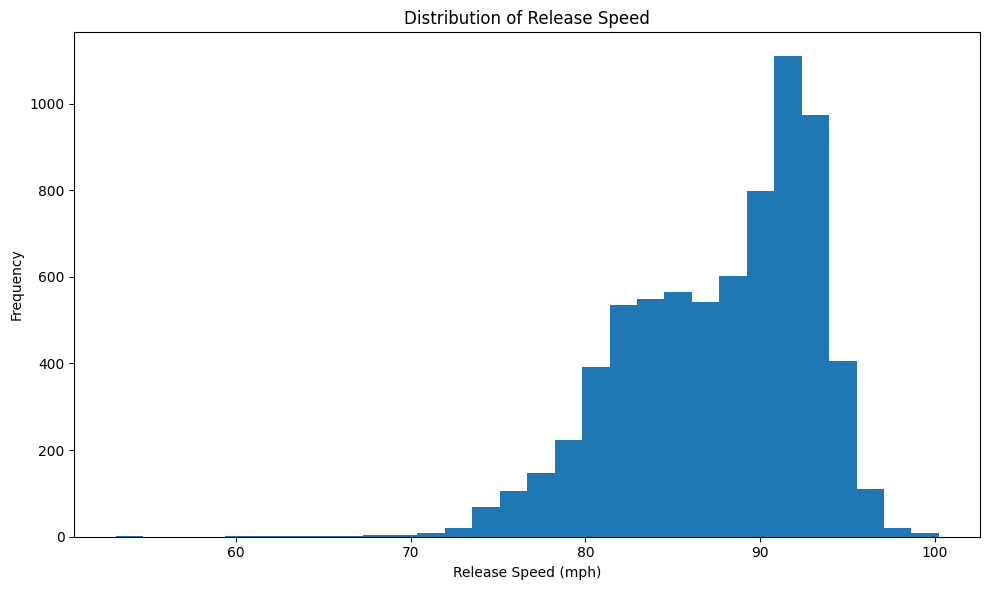

In [27]:
import matplotlib.pyplot as plt

df['ball_strike_sum'] = df.get('ball_strike_sum', df['Balls'] + df['Strikes'])

count_pivot = df.groupby(['ball_strike_sum', 'AutoPitchType']).size().unstack(fill_value=0)
ax = count_pivot.plot(kind='bar', figsize=(10, 6))
ax.set_xlabel('Sum of Balls and Strikes')
ax.set_ylabel('Number of Pitches')
ax.set_title('Pitch Type Distribution by Count')
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 6))
for pt in df['AutoPitchType'].unique():
    subset = df[df['AutoPitchType'] == pt]
    plt.scatter(subset['RelSpeed'], subset['VertRelAngle'], label=pt, alpha=0.6)
plt.xlabel('Release Speed (mph)')
plt.ylabel('Vertical Release Angle (°)')
plt.title('Release Speed vs. Vertical Release Angle by Pitch Type')
plt.legend(title='Pitch Type', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 6))
plt.hist(df['RelSpeed'].dropna(), bins=30)
plt.xlabel('Release Speed (mph)')
plt.ylabel('Frequency')
plt.title('Distribution of Release Speed')
plt.tight_layout()
plt.show()